In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

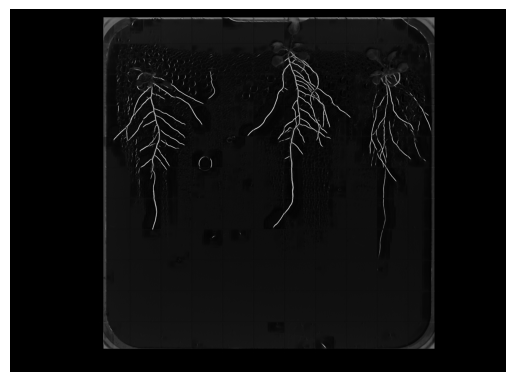

In [2]:
test_path = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task5/02_task5/task5_test_image_prediction_rayanedaborisova_220471.png'
test_loaded = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
test_loaded = test_loaded * 255  # Scale the image to 0-255 range

plt.imshow(test_loaded, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
def close_small_gaps(mask, threshold=0.1, iterations=3, kernel_size=(5, 3)):
    binary = (mask > int(threshold * 255)).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    closed = binary.copy()
    for _ in range(iterations):
        closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel)

    return closed

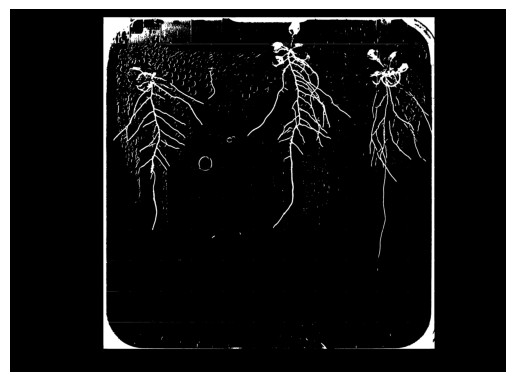

In [4]:
mask_closed = close_small_gaps(test_loaded, threshold=0.1)

plt.imshow(mask_closed, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def crop_empty_columns(mask, padding=20):
    """Remove empty columns on the sides (with an optional safety margin)."""
    occupied_columns = np.where(mask.sum(axis=0) > 0)[0]
    if occupied_columns.size == 0:                     # mask is all zeros
        return mask, (0, 0)

    left_crop  = max(occupied_columns[0] - padding, 0)
    right_crop = max(mask.shape[1] - occupied_columns[-1] - 1 - padding, 0)

    cropped_mask = mask[:, left_crop:mask.shape[1] - right_crop]
    return cropped_mask, (left_crop, right_crop)

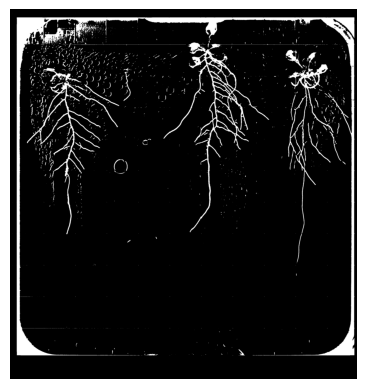

In [6]:
mask_cropped, (left_crop, right_crop) = crop_empty_columns(mask_closed, padding=20)

plt.imshow(mask_cropped, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
def components_touch(mask_a, mask_b, max_pixel_dist=15):
    kernel = np.ones((max_pixel_dist * 2 + 1, max_pixel_dist * 2 + 1), dtype=np.uint8)
    dilated = cv2.dilate(mask_a.astype(np.uint8), kernel, iterations=1)
    return np.any(np.logical_and(dilated, mask_b))

In [8]:
def segment_roots(mask, min_area=300, max_gap_px=20, num_roots=5, min_px_per_root=350):

    # Find connected components in the cropped mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    comp_masks = []
    comp_centroids = []

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            mask_mask = (labels == i).astype(np.uint8)
            comp_masks.append(mask_mask)
            comp_centroids.append(centroids[i])

    # 1. Find components that are close enough to be parts of the same root
    merged_masks = []    
    used = [False] * len(comp_masks)

    for i in range(len(comp_masks)):
        if used[i]:
            continue
        merged = comp_masks[i].copy()
        used[i] = True
        for j in range(i + 1, len(comp_masks)):
            if not used[j] and components_touch(merged, comp_masks[j], max_gap_px):
                merged = np.logical_or(merged, comp_masks[j])
                used[j] = True
        merged_masks.append(merged.astype(np.uint8))

    # 3. calculate centroids
    centroids = []
    for m in merged_masks:
        ys, xs = np.where(m)
        if xs.size:
            centroids.append([xs.mean(), ys.mean()])
    centroids = np.asarray(centroids)

    # 4. cluster blobs with K-means so we end up with ≤ target root count
    if centroids.size == 0:
        # nothing found – return blanks
        blank = np.zeros_like(mask_mask, np.uint8)
        return [blank.copy() for _ in range(num_roots)]

    k = min(len(centroids), num_roots)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(centroids)

    cluster_masks = [np.zeros_like(mask, np.uint8) for _ in range(k)]
    for idx, m in enumerate(merged_masks):
        cluster_masks[labels[idx]] |= m

    # 6. keep sizeable clusters, sort by horizontal position, pad to target
    def average_x_coordinate(mask_mask):
        xs = np.where(mask_mask)[1]
        return xs.mean() if xs.size else np.inf

    clusters_with_x = [
        (idx, average_x_coordinate(mask_mask))
        for idx, mask_mask in enumerate(cluster_masks)
        if mask_mask.sum() >= min_px_per_root
    ]
    while len(clusters_with_x) < num_roots:
        clusters_with_x.append((None, np.inf))

    sorted_clusters = sorted(clusters_with_x, key=lambda pair: pair[1])

    final_root_masks: list[np.ndarray] = []
    for cluster_index, _ in sorted_clusters:
        if cluster_index is None:
            final_root_masks.append(
                np.zeros_like(mask, np.uint8)
            )
        else:
            final_root_masks.append(
                (cluster_masks[cluster_index] * 255).astype(np.uint8)
            )

    return final_root_masks

In [9]:
root_masks = segment_roots(mask_cropped, min_area=2_000, max_gap_px=20, num_roots=5, min_px_per_root=8_000)
print('Masks returned:', len(root_masks))

Masks returned: 5


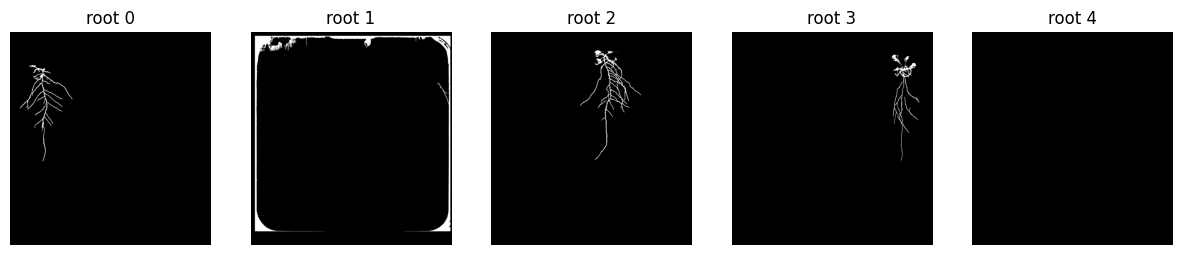

In [10]:
root1_mask, root2_mask, root3_mask, root4_mask, root5_mask = root_masks

plt.figure(figsize=(15, 5))
for i, m in enumerate(root_masks):
    plt.subplot(1, 5, i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f'root {i}')
    plt.axis('off')
plt.show()

# for i, m in enumerate(root_masks, start=1):
#     plt.imshow(m, cmap='gray')
#     plt.title(f'Root {i}')
#     plt.axis('off')
#     plt.show()

In [11]:
import os

save_dir = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/02_task6'

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the entire figure with all root masks
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, m in enumerate(root_masks):
    axs[i].imshow(m, cmap='gray')
    axs[i].set_title(f"root {i}")
    axs[i].axis('off')

# Save the full figure to disk
full_figure_path = os.path.join(save_dir, "02_task6_roots.png")
plt.savefig(full_figure_path, bbox_inches='tight')
print(f"Saved combined figure: {full_figure_path}")
plt.close()


Saved combined figure: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/02_task6/02_task6_roots.png
